In [1]:
# Imports & seed
import os, random
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import zscore
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE

import joblib
import warnings
warnings.filterwarnings("ignore")

# tensorflow/Keras imports for autoencoder
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

tf.random.set_seed(SEED)


In [2]:
# Define file paths
file_path_with_infertility = "data\PCOS_infertility.csv"
file_path_without_infertility = "data\PCOS_data_without_infertility.xlsx"

# Load data
PCOS_inf = pd.read_csv(file_path_with_infertility)
PCOS_woinf = pd.read_excel(file_path_without_infertility, sheet_name="Full_new")

# Merge datasets based on 'Patient File No.'
data = pd.merge(PCOS_woinf, PCOS_inf, on='Patient File No.', suffixes=('', '_y'), how='left')

# Drop duplicated or unnecessary columns
columns_to_drop = ['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', 
                   '  I   beta-HCG(mIU/mL)_y', 'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y']
data = data.drop(columns=columns_to_drop, errors='ignore')

# Display first few rows
data.head()


,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,1,1,0,28,44.6,152.0,19.300000,15,78,22,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,2,2,0,36,65.0,161.5,24.921163,15,74,20,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,3,3,1,33,68.8,165.0,25.270891,11,72,18,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,4,4,0,37,65.0,148.0,29.674945,13,72,20,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,5,5,0,25,52.0,161.0,20.060954,11,72,18,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3    Age (yrs)              541 non-null    int64  
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    float64
 7   Blood Group             541 non-null    int64  
 8   Pulse rate(bpm)         541 non-null    int64  
 9   RR (breaths/min)        541 non-null    int64  
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    int64  
 12  Cycle length(days)      541 non-null    int64  
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    in

In [4]:
# Load dataset 
summary_table = data.describe().T  # Transpose for better readability
summary_table[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]


,mean,std,min,25%,50%,75%,max
Sl. No,271.000000,156.317519,1.000000,136.000000,271.000000,406.000000,541.000000
Patient File No.,271.000000,156.317519,1.000000,136.000000,271.000000,406.000000,541.000000
PCOS (Y/N),0.327172,0.469615,0.000000,0.000000,0.000000,1.000000,1.000000
Age (yrs),31.430684,5.411006,20.000000,28.000000,31.000000,35.000000,48.000000
Weight (Kg),59.637153,11.028287,31.000000,52.000000,59.000000,65.000000,108.000000
Height(Cm),156.484835,6.033545,137.000000,152.000000,156.000000,160.000000,180.000000
BMI,24.311285,4.056399,12.417882,21.641274,24.238227,26.634958,38.900000
Blood Group,13.802218,1.840812,11.000000,13.000000,14.000000,15.000000,18.000000
Pulse rate(bpm),73.247689,4.430285,13.000000,72.000000,72.000000,74.000000,82.000000
RR (breaths/min),19.243993,1.688629,16.000000,18.000000,18.000000,20.000000,28.000000


In [5]:
data.shape

(541, 44)

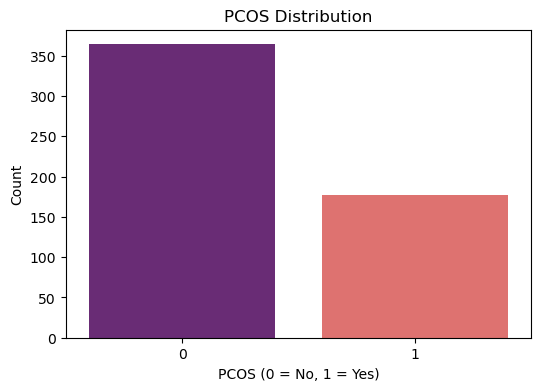

In [6]:
# Creating a count plot to visualize how many individuals have PCOS vs. those who don't
plt.figure(figsize=(6, 4))  # Set the plot size
sns.countplot(x='PCOS (Y/N)', data=data, palette='magma')  
plt.title("PCOS Distribution")  # Title for context
plt.xlabel("PCOS (0 = No, 1 = Yes)")  
plt.ylabel("Count")  # Label the y-axis
plt.show()  # Display the plot


In [7]:
# Calculate the percentage of individuals with and without PCOS
pcos_counts = data['PCOS (Y/N)'].value_counts(normalize=True) * 100
print(f"PCOS Positive: {pcos_counts[1]:.2f}%")  # Print percentage of positive cases
print(f"PCOS Negative: {pcos_counts[0]:.2f}%")  # Print percentage of negative cases


PCOS Positive: 32.72%
PCOS Negative: 67.28%


In [8]:
# Extract BMI values for PCOS and non-PCOS groups
bmi_pcos = data[data['PCOS (Y/N)'] == 1]['BMI']
bmi_non_pcos = data[data['PCOS (Y/N)'] == 0]['BMI']

# Calculate the average BMI for both groups
mean_pcos_bmi = np.mean(bmi_pcos)
mean_non_pcos_bmi = np.mean(bmi_non_pcos)

# Display average BMI comparison
print(f"Average BMI of PCOS Patients: {mean_pcos_bmi:.2f}")
print(f"Average BMI of Non-PCOS Patients: {mean_non_pcos_bmi:.2f}")


Average BMI of PCOS Patients: 25.47
Average BMI of Non-PCOS Patients: 23.75


In [9]:
# Perform a statistical t-test to compare LH (Luteinizing Hormone) levels between PCOS and non-PCOS groups
lh_pcos = data[data['PCOS (Y/N)'] == 1]['LH(mIU/mL)']
lh_non_pcos = data[data['PCOS (Y/N)'] == 0]['LH(mIU/mL)']

t_stat, p_value = stats.ttest_ind(lh_pcos, lh_non_pcos, equal_var=False)  # Welch’s t-test used due to unequal variance
print(f"T-test for LH levels: p-value = {p_value:.5f}")  # A low p-value indicates significant difference

T-test for LH levels: p-value = 0.30189


In [10]:
# Repeat the t-test process for FSH (Follicle-Stimulating Hormone) levels
fsh_pcos = data[data['PCOS (Y/N)'] == 1]['FSH(mIU/mL)']
fsh_non_pcos = data[data['PCOS (Y/N)'] == 0]['FSH(mIU/mL)']

t_stat, p_value = stats.ttest_ind(fsh_pcos, fsh_non_pcos, equal_var=False)
print(f"T-test for FSH levels: p-value = {p_value:.5f}")  # Useful to detect hormonal differences


T-test for FSH levels: p-value = 0.31317


In [11]:
# Irregular cycles pattern
irregular_cycles_pcos = data[data['PCOS (Y/N)'] == 1]['Cycle(R/I)'].value_counts(normalize=True) * 100
irregular_cycles_non_pcos = data[data['PCOS (Y/N)'] == 0]['Cycle(R/I)'].value_counts(normalize=True) * 100

print(f"PCOS Patients - Irregular Cycles: {irregular_cycles_pcos.get(1, 0):.2f}%")
print(f"Non-PCOS Patients - Irregular Cycles: {irregular_cycles_non_pcos.get(1, 0):.2f}%")


PCOS Patients - Irregular Cycles: 0.00%
Non-PCOS Patients - Irregular Cycles: 0.00%


In [12]:
# Investigate pregnancy status among PCOS patients
# 'Pregnant(Y/N)' might indicate prior pregnancy experience

infertility_pcos = data[data['PCOS (Y/N)'] == 1]['Pregnant(Y/N)'].value_counts(normalize=True) * 100

# Print the proportion of PCOS patients who have and have not been pregnant
print(f"Percentage of PCOS patients who have been pregnant: {infertility_pcos.get(1, 0):.2f}%")
print(f"Percentage of PCOS patients who have not been pregnant: {infertility_pcos.get(0, 0):.2f}%")


Percentage of PCOS patients who have been pregnant: 36.16%
Percentage of PCOS patients who have not been pregnant: 63.84%


In [13]:
# Create a summary table to compare mean values of key metrics across PCOS and non-PCOS groups
comparison_table = data.groupby('PCOS (Y/N)')[[' Age (yrs)', 'BMI', 'LH(mIU/mL)', 'FSH(mIU/mL)', 'Vit D3 (ng/mL)']].mean()

# Replace the binary index with human-readable labels
comparison_table.index = ['Non-PCOS', 'PCOS']

# Display the resulting summary table
comparison_table


,Age (yrs),BMI,LH(mIU/mL),FSH(mIU/mL),Vit D3 (ng/mL)
Non-PCOS,32.065934,23.747397,2.612676,19.185956,29.295005
PCOS,30.124294,25.470919,14.402328,5.174593,92.322633


In [14]:
# Selecting relevant columns
features = [' Age (yrs)', 'BMI', 'LH(mIU/mL)', 'FSH(mIU/mL)', 'Vit D3 (ng/mL)']
summary_table = data[features].describe().T[['mean', '50%', 'std', 'min', 'max']]
summary_table.columns = ['Mean', 'Median', 'Std Dev', 'Min', 'Max']

# Display the table
summary_table


,Mean,Median,Std Dev,Min,Max
Age (yrs),31.430684,31.000000,5.411006,20.000000,48.00
BMI,24.311285,24.238227,4.056399,12.417882,38.90
LH(mIU/mL),6.469919,2.300000,86.673255,0.020000,2018.00
FSH(mIU/mL),14.601832,4.850000,217.022081,0.210000,5052.00
Vit D3 (ng/mL),49.915874,25.900000,346.206599,0.000000,6014.66


In [15]:
# Defining PCOS & Non-PCOS groups
pcos_group = data[data['PCOS (Y/N)'] == 1]
non_pcos_group = data[data['PCOS (Y/N)'] == 0]

# Performing t-tests
t_test_results = {
    'Feature': ['LH(mIU/mL)', 'FSH(mIU/mL)', 'BMI', 'Vit D3 (ng/mL)'],
    'P-Value': [
        ttest_ind(pcos_group['LH(mIU/mL)'], non_pcos_group['LH(mIU/mL)'], nan_policy='omit').pvalue,
        ttest_ind(pcos_group['FSH(mIU/mL)'], non_pcos_group['FSH(mIU/mL)'], nan_policy='omit').pvalue,
        ttest_ind(pcos_group['BMI'], non_pcos_group['BMI'], nan_policy='omit').pvalue,
        ttest_ind(pcos_group['Vit D3 (ng/mL)'], non_pcos_group['Vit D3 (ng/mL)'], nan_policy='omit').pvalue
    ]
}

t_test_df = pd.DataFrame(t_test_results)
t_test_df


,Feature,P-Value
0,LH(mIU/mL),0.137845
1,FSH(mIU/mL),0.481596
2,BMI,0.000003
3,Vit D3 (ng/mL),0.046857


In [16]:
# Create a new binary column indicating Vitamin D deficiency status (threshold: < 20 ng/mL)
data['Vit D Deficient'] = data['Vit D3 (ng/mL)'] < 20

# Calculate percentage of Vitamin D deficient and sufficient individuals within PCOS and Non-PCOS groups
vit_d_table = data.groupby('PCOS (Y/N)')['Vit D Deficient'].value_counts(normalize=True) * 100

# Reshape the results to make it easier to interpret as a table
vit_d_table = vit_d_table.unstack()

vit_d_table.columns = ['Sufficient (%)', 'Deficient (%)']
vit_d_table.index = ['Non-PCOS', 'PCOS']  

# Display the percentage of Vitamin D sufficiency/deficiency in both groups
vit_d_table



,Sufficient (%),Deficient (%)
Non-PCOS,81.043956,18.956044
PCOS,71.751412,28.248588


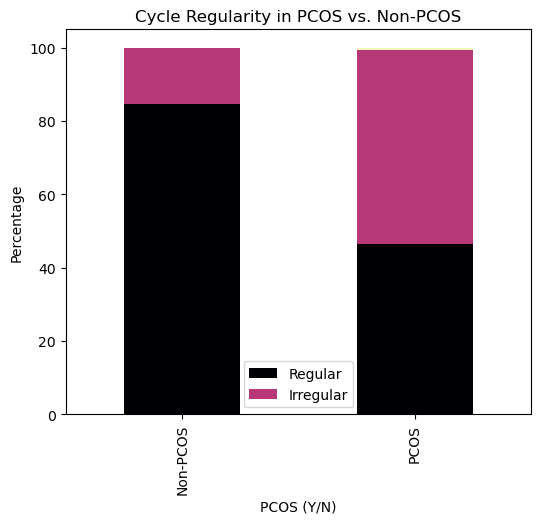

In [17]:
# Analyze cycle regularity (Regular vs Irregular) as a percentage within each PCOS class
cycle_counts = data.groupby('PCOS (Y/N)')['Cycle(R/I)'].value_counts(normalize=True).unstack() * 100

# Plot a stacked bar chart to compare cycle regularity between PCOS and Non-PCOS groups
cycle_counts.plot(
    kind='bar', 
    stacked=True, 
    colormap='magma', 
    figsize=(6,5)
)
plt.xticks([0,1], ['Non-PCOS', 'PCOS']) 
plt.ylabel("Percentage")
plt.title("Cycle Regularity in PCOS vs. Non-PCOS")
plt.legend(["Regular", "Irregular"])  
plt.show()


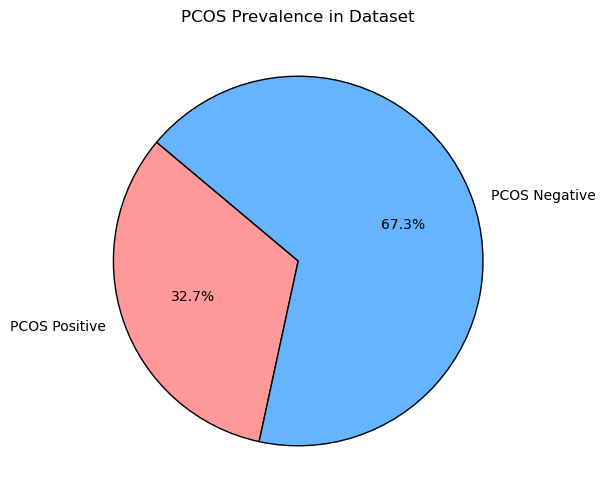

In [18]:
# Create a pie chart to visualize overall PCOS prevalence in the dataset

labels = ['PCOS Positive', 'PCOS Negative']  # Define pie segments
sizes = [32.72, 67.28]  
colors = ['#FF9999', '#66B3FF']  

plt.figure(figsize=(6,6))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%',  # Show percentage values on pie
    colors=colors, 
    startangle=140,  # Rotate the pie 
    wedgeprops={'edgecolor': 'black'}  # black edge for better visibility
)
plt.title("PCOS Prevalence in Dataset")
plt.show()


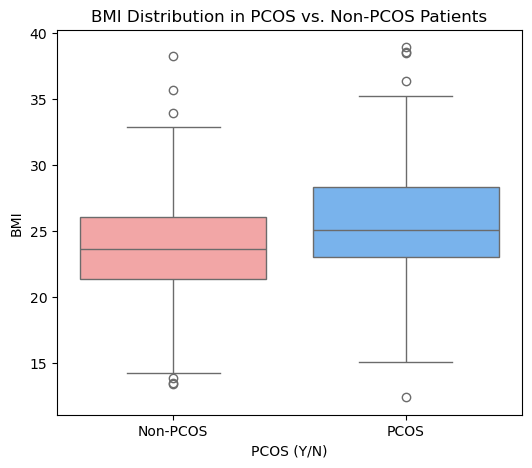

In [19]:
# Create a boxplot to visualize the distribution of BMI across PCOS and Non-PCOS patients

plt.figure(figsize=(6,5))
sns.boxplot(
    x='PCOS (Y/N)', 
    y='BMI', 
    data=data, 
    palette=['#FF9999', '#66B3FF'] 
)
plt.xticks([0,1], ['Non-PCOS', 'PCOS']) 
plt.title("BMI Distribution in PCOS vs. Non-PCOS Patients")  
plt.show()


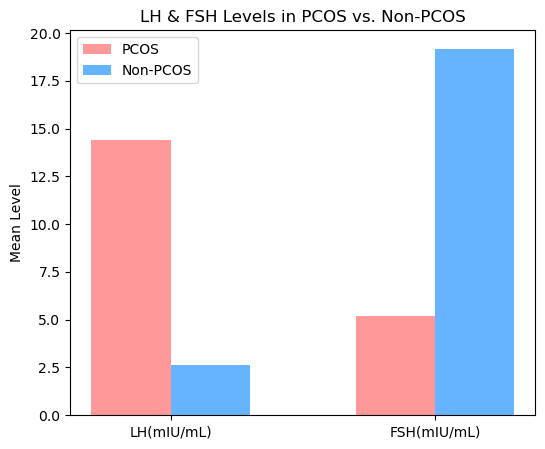

In [20]:
# Compare mean levels of two hormones (LH and FSH) between PCOS and Non-PCOS groups using a grouped bar chart
hormones = ['LH(mIU/mL)', 'FSH(mIU/mL)']  # Hormones of interest

# Calculate mean hormone levels for PCOS group
means_pcos = [
    data[data['PCOS (Y/N)'] == 1]['LH(mIU/mL)'].mean(), 
    data[data['PCOS (Y/N)'] == 1]['FSH(mIU/mL)'].mean()
]

# same for Non-PCOS group
means_non_pcos = [
    data[data['PCOS (Y/N)'] == 0]['LH(mIU/mL)'].mean(), 
    data[data['PCOS (Y/N)'] == 0]['FSH(mIU/mL)'].mean()
]

x = np.arange(len(hormones))  # X-axis positions for bars
width = 0.3  

# Create the bar chart
fig, ax = plt.subplots(figsize=(6,5))
ax.bar(x - width/2, means_pcos, width, label='PCOS', color='#FF9999')  # PCOS bars
ax.bar(x + width/2, means_non_pcos, width, label='Non-PCOS', color='#66B3FF')  # Non-PCOS bars

# Format the plot
ax.set_xticks(x)
ax.set_xticklabels(hormones)
ax.set_ylabel('Mean Level')
ax.set_title('LH & FSH Levels in PCOS vs. Non-PCOS')
ax.legend()
plt.show()


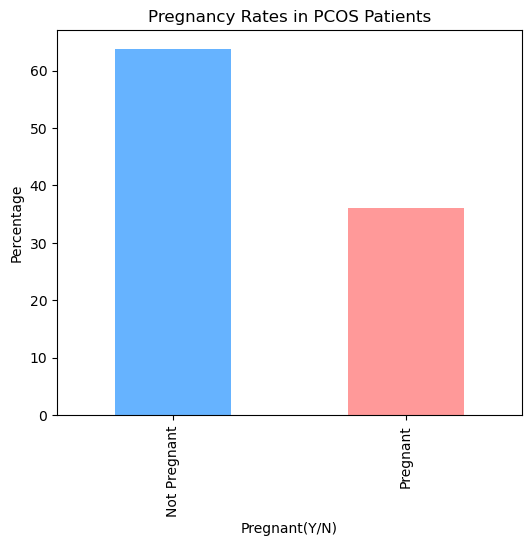

In [21]:
# Analyze pregnancy status distribution among PCOS patients

pregnancy_counts = data[data['PCOS (Y/N)'] == 1]['Pregnant(Y/N)'].value_counts(normalize=True) * 100

# Plot a simple bar chart to show pregnancy rates within PCOS patients
pregnancy_counts.plot(
    kind='bar', 
    color=['#66B3FF', '#FF9999'], 
    figsize=(6,5)
)
plt.xticks([0,1], ['Not Pregnant', 'Pregnant'])  
plt.ylabel("Percentage")
plt.title("Pregnancy Rates in PCOS Patients")
plt.show()



In [22]:
# Checking for missing values
missing_values = data.isnull().sum()

# Display columns with missing values
missing_values[missing_values > 0]

Marraige Status (Yrs)    1
Fast food (Y/N)          1
dtype: int64

In [23]:
# Handling missing values 
data.fillna(data.median(numeric_only=True), inplace=True)  # Filling numerical missing values with median


In [24]:
# Checking for missing values
missing_values = data.isnull().sum()

# Display columns with missing values
missing_values[missing_values > 0]

Series([], dtype: int64)

In [25]:
# Checking for duplicate rows
duplicate_rows = data.duplicated().sum()
print(f"Total duplicate rows: {duplicate_rows}")

# Dropping duplicate rows
data = data.drop_duplicates()


Total duplicate rows: 0


In [26]:
# Calculating Z-scores
z_scores = data.select_dtypes(include=['number']).apply(zscore)

# Setting threshold (e.g., |z| > 3 indicates an outlier)
outliers = (z_scores.abs() > 3).sum()
print(outliers[outliers > 0])  # Display features with outliers


 Age (yrs)                 1
Weight (Kg)                3
Height(Cm)                 2
BMI                        4
Pulse rate(bpm)            2
RR (breaths/min)           3
Hb(g/dl)                   8
Cycle length(days)         9
Marraige Status (Yrs)      7
No. of aborptions         13
  I   beta-HCG(mIU/mL)     9
FSH(mIU/mL)                1
LH(mIU/mL)                 1
FSH/LH                     2
Hip(inch)                  3
Waist(inch)                3
TSH (mIU/L)                9
PRL(ng/mL)                 9
Vit D3 (ng/mL)             2
PRG(ng/mL)                 2
RBS(mg/dl)                 4
BP _Systolic (mmHg)        3
BP _Diastolic (mmHg)       3
Follicle No. (L)           6
Follicle No. (R)           6
Avg. F size (L) (mm)       8
Avg. F size (R) (mm)       5
Endometrium (mm)           6
dtype: int64


In [ ]:
# Define target and feature groups
target = 'PCOS (Y/N)'
assert target in data.columns, "Target column missing in df"

# Drop identifiers if present from modeling later
identifier_cols = [c for c in ['Sl. No', 'Patient File No.'] if c in data.columns]

# Basic column typing
raw_X = data.drop(columns=[target] + identifier_cols)
y = data[target].astype(int)

# object dtype columns - categorical candidates
obj_cols = raw_X.select_dtypes(include=['object', 'category']).columns.tolist()

# numeric columns
num_cols = raw_X.select_dtypes(include=[np.number]).columns.tolist()

# numeric but low-cardinality - treat as categorical (heuristic)
low_card_num = [c for c in num_cols if raw_X[c].nunique() <= 10]
# If any of these truly represent numerical measurements, remove them from low_card_num.
print("Detected object columns (will treat as categorical):", obj_cols)
print("Numeric low-cardinality (consider as categorical):", low_card_num)

# final categorical columns to use for SMOTENC/ordinal encoding
cat_cols = sorted(set(obj_cols + low_card_num))
# final numeric columns (exclude those moved to categorical)
num_cols = [c for c in num_cols if c not in cat_cols]

print("Final numeric cols count:", len(num_cols), "Final categorical cols count:", len(cat_cols))


Detected object columns (will treat as categorical): ['II    beta-HCG(mIU/mL)', 'AMH(ng/mL)']
Numeric low-cardinality (consider as categorical): ['Blood Group', 'RR (breaths/min)', 'Cycle(R/I)', 'Pregnant(Y/N)', 'No. of aborptions', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)', 'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)', 'BP _Diastolic (mmHg)']
Final numeric cols count: 25 Final categorical cols count: 16


In [28]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=300, max_depth=20, random_state=SEED, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(random_state=SEED),
    'Gaussian NB': GaussianNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='liblinear', random_state=SEED)
}

N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

# Prepare structure to store results
results = {name: {'acc': [], 'f1': [], 'precision': [], 'recall': []} for name in models.keys()}

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(skf.split(raw_X, y), 1):
    print(f"\n=== Fold {fold}/{N_SPLITS} ===")

    X_train_raw = raw_X.iloc[train_idx].reset_index(drop=True)
    X_val_raw = raw_X.iloc[val_idx].reset_index(drop=True)
    y_train = y.iloc[train_idx].reset_index(drop=True)
    y_val = y.iloc[val_idx].reset_index(drop=True)

    # Impute missing values
    X_train_imp = X_train_raw.copy()
    X_val_imp = X_val_raw.copy()

    # Impute numeric columns with median
    for c in num_cols:
        med = X_train_imp[c].median()
        X_train_imp[c] = X_train_imp[c].fillna(med)
        X_val_imp[c] = X_val_imp[c].fillna(med)

    # Impute categorical columns with mode
    for c in cat_cols:
        mode = X_train_imp[c].mode().iloc[0] if X_train_imp[c].notna().any() else "missing"
        X_train_imp[c] = X_train_imp[c].fillna(mode)
        X_val_imp[c] = X_val_imp[c].fillna(mode)

    # Ensure categorical columns are all strings (prevents mixed-type encoder errors)
    if cat_cols:
        X_train_imp[cat_cols] = X_train_imp[cat_cols].astype(str)
        X_val_imp[cat_cols] = X_val_imp[cat_cols].astype(str)

    # Ordinal Encoding for categorical features
    if cat_cols:
        ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        ord_enc.fit(X_train_imp[cat_cols])
        X_train_cat = ord_enc.transform(X_train_imp[cat_cols]).astype(int)
        X_val_cat = ord_enc.transform(X_val_imp[cat_cols]).astype(int)
    else:
        X_train_cat = np.empty((len(X_train_imp), 0))
        X_val_cat = np.empty((len(X_val_imp), 0))

    # Convert numeric columns to arrays
    X_train_num = X_train_imp[num_cols].to_numpy(dtype=float) if num_cols else np.empty((len(X_train_imp), 0))
    X_val_num = X_val_imp[num_cols].to_numpy(dtype=float) if num_cols else np.empty((len(X_val_imp), 0))

    # Concatenate numeric + categorical columns
    X_train_for_smote = np.hstack([X_train_num, X_train_cat]) if X_train_cat.size else X_train_num
    X_val_for_model = np.hstack([X_val_num, X_val_cat]) if X_val_cat.size else X_val_num

    # Identify categorical feature indices for SMOTENC
    if cat_cols:
        cat_start = X_train_num.shape[1]
        categorical_feature_indices = list(range(cat_start, cat_start + X_train_cat.shape[1]))
    else:
        categorical_feature_indices = []

    # Apply SMOTENC / SMOTE
    if len(categorical_feature_indices) > 0:
        sm = SMOTENC(categorical_features=categorical_feature_indices, random_state=SEED)
    else:
        sm = SMOTE(random_state=SEED)

    X_train_res_arr, y_train_res = sm.fit_resample(X_train_for_smote, y_train.values)

    # Scale only numeric columns (fit on resampled training set)
    if num_cols:
        scaler = StandardScaler()
        X_train_res_num = scaler.fit_transform(X_train_res_arr[:, :len(num_cols)])
        X_val_num_scaled = scaler.transform(X_val_for_model[:, :len(num_cols)])
    else:
        X_train_res_num = np.empty((X_train_res_arr.shape[0], 0))
        X_val_num_scaled = np.empty((X_val_for_model.shape[0], 0))

    # Reconstruct numeric + categorical parts after scaling
    if X_train_res_arr.shape[1] - len(num_cols) > 0:
        X_train_res_cat = X_train_res_arr[:, len(num_cols):].astype(int)
        X_val_cat_ord = X_val_for_model[:, len(num_cols):].astype(int) if X_val_for_model.shape[1] - len(num_cols) > 0 else np.empty((len(X_val_for_model), 0))
    else:
        X_train_res_cat = np.empty((X_train_res_arr.shape[0], 0))
        X_val_cat_ord = np.empty((len(X_val_for_model), 0))

    # Final train/validation arrays
    X_train_final = np.hstack([X_train_res_num, X_train_res_cat]) if X_train_res_cat.size else X_train_res_num
    X_val_final = np.hstack([X_val_num_scaled, X_val_cat_ord]) if X_val_cat_ord.size else X_val_num_scaled

    # Train and evaluate each model
    for name, model in models.items():
        m = model
        m.fit(X_train_final, y_train_res)
        y_pred = m.predict(X_val_final)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='weighted')
        prec = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_val, y_pred, average='weighted')

        results[name]['acc'].append(acc)
        results[name]['f1'].append(f1)
        results[name]['precision'].append(prec)
        results[name]['recall'].append(rec)

        print(f"{name:<22} acc: {acc:.4f}, f1: {f1:.4f}, prec: {prec:.4f}, rec: {rec:.4f}")

# Summary of Results
print("\n Cross-Validation Summary ")
summary_df = pd.DataFrame({
    model: {
        'Accuracy': np.mean(res['acc']),
        'F1-score': np.mean(res['f1']),
        'Precision': np.mean(res['precision']),
        'Recall': np.mean(res['recall'])
    }
    for model, res in results.items()
}).T.round(4)

display(summary_df)



=== Fold 1/5 ===
Random Forest          acc: 0.9266, f1: 0.9271, prec: 0.9282, rec: 0.9266
Decision Tree          acc: 0.8165, f1: 0.8177, prec: 0.8195, rec: 0.8165
Gaussian NB            acc: 0.7064, f1: 0.7136, prec: 0.8028, rec: 0.7064
Logistic Regression    acc: 0.9083, f1: 0.9094, prec: 0.9131, rec: 0.9083

=== Fold 2/5 ===
Random Forest          acc: 0.8426, f1: 0.8407, prec: 0.8402, rec: 0.8426
Decision Tree          acc: 0.8241, f1: 0.8234, prec: 0.8229, rec: 0.8241
Gaussian NB            acc: 0.8333, f1: 0.8376, prec: 0.8563, rec: 0.8333
Logistic Regression    acc: 0.8611, f1: 0.8633, prec: 0.8693, rec: 0.8611

=== Fold 3/5 ===
Random Forest          acc: 0.9352, f1: 0.9349, prec: 0.9349, rec: 0.9352
Decision Tree          acc: 0.8148, f1: 0.8172, prec: 0.8219, rec: 0.8148
Gaussian NB            acc: 0.8241, f1: 0.8219, prec: 0.8212, rec: 0.8241
Logistic Regression    acc: 0.9074, f1: 0.9086, prec: 0.9124, rec: 0.9074

=== Fold 4/5 ===
Random Forest          acc: 0.9444, f1: 

,Accuracy,F1-score,Precision,Recall
Random Forest,0.9075,0.9070,0.9071,0.9075
Decision Tree,0.8170,0.8177,0.8205,0.8170
Gaussian NB,0.8024,0.8056,0.8314,0.8024
Logistic Regression,0.8891,0.8907,0.8967,0.8891


In [ ]:
# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Data Preparation
identifier_cols = [c for c in ['Sl. No', 'Patient File No.'] if c in data.columns]

raw_X = data.drop(columns=[target] + identifier_cols)
y = data[target].astype(int)

obj_cols = raw_X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = raw_X.select_dtypes(include=[np.number]).columns.tolist()
low_card_num = [c for c in num_cols if raw_X[c].nunique() <= 10]

cat_cols = sorted(set(obj_cols + low_card_num))
num_cols = [c for c in num_cols if c not in cat_cols]

print(f"Numeric cols: {len(num_cols)}, Categorical cols: {len(cat_cols)}")

#  Cross-Validation Setup
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

fold_f1_scores = []
fold_acc_scores = []

# To store final predictions for visualization
all_y_true = []
all_y_pred = []

# CV Loop: SMOTE - Autoencoder - RF
for fold, (train_idx, val_idx) in enumerate(skf.split(raw_X, y), 1):
    print(f"\n=== Fold {fold}/{N_SPLITS} ===")
    
    # Split data
    X_train_raw = raw_X.iloc[train_idx].reset_index(drop=True)
    X_val_raw = raw_X.iloc[val_idx].reset_index(drop=True)
    y_train = y.iloc[train_idx].reset_index(drop=True)
    y_val = y.iloc[val_idx].reset_index(drop=True)

    # Imputation
    X_train_imp = X_train_raw.copy()
    X_val_imp = X_val_raw.copy()
    
    for c in num_cols:
        med = X_train_imp[c].median()
        X_train_imp[c] = X_train_imp[c].fillna(med)
        X_val_imp[c] = X_val_imp[c].fillna(med)
        
    for c in cat_cols:
        mode = X_train_imp[c].mode().iloc[0] if X_train_imp[c].notna().any() else "missing"
        X_train_imp[c] = X_train_imp[c].fillna(mode)
        X_val_imp[c] = X_val_imp[c].fillna(mode)
        
    if cat_cols:
        X_train_imp[cat_cols] = X_train_imp[cat_cols].astype(str)
        X_val_imp[cat_cols] = X_val_imp[cat_cols].astype(str)
    
    # Encoding categorical
    if cat_cols:
        ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        ord_enc.fit(X_train_imp[cat_cols])
        X_train_cat = ord_enc.transform(X_train_imp[cat_cols]).astype(int)
        X_val_cat = ord_enc.transform(X_val_imp[cat_cols]).astype(int)
    else:
        X_train_cat = np.empty((len(X_train_imp), 0))
        X_val_cat = np.empty((len(X_val_imp), 0))
    
    X_train_num = X_train_imp[num_cols].to_numpy(dtype=float) if num_cols else np.empty((len(X_train_imp), 0))
    X_val_num = X_val_imp[num_cols].to_numpy(dtype=float) if num_cols else np.empty((len(X_val_imp), 0))
    
    X_train_for_smote = np.hstack([X_train_num, X_train_cat]) if X_train_cat.size else X_train_num
    X_val_for_model = np.hstack([X_val_num, X_val_cat]) if X_val_cat.size else X_val_num
    

    # SMOTE / SMOTENC
    if cat_cols:
        cat_start = X_train_num.shape[1]
        cat_indices = list(range(cat_start, cat_start + X_train_cat.shape[1]))
        sm = SMOTENC(categorical_features=cat_indices, random_state=SEED)
    else:
        sm = SMOTE(random_state=SEED)
    
    X_train_res_arr, y_train_res = sm.fit_resample(X_train_for_smote, y_train.values)
    
    # Scale numeric
    if num_cols:
        scaler = StandardScaler()
        X_train_res_num = scaler.fit_transform(X_train_res_arr[:, :len(num_cols)])
        X_val_num_scaled = scaler.transform(X_val_for_model[:, :len(num_cols)])
    else:
        X_train_res_num = np.empty((X_train_res_arr.shape[0], 0))
        X_val_num_scaled = np.empty((X_val_for_model.shape[0], 0))
    
    # Extract categorical part
    if X_train_res_arr.shape[1] - len(num_cols) > 0:
        X_train_res_cat = X_train_res_arr[:, len(num_cols):].astype(int)
        X_val_cat_ord = X_val_for_model[:, len(num_cols):].astype(int) if X_val_for_model.shape[1] - len(num_cols) > 0 else np.empty((len(X_val_for_model), 0))
    else:
        X_train_res_cat = np.empty((X_train_res_arr.shape[0], 0))
        X_val_cat_ord = np.empty((len(X_val_for_model), 0))
    

    # Autoencoder
    input_dim = X_train_res_num.shape[1]
    encoding_dim = 64

    inp = Input(shape=(input_dim,))
    x = Dense(128, activation='relu')(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    encoded_layer = Dense(encoding_dim, activation='relu')(x)
    x = Dense(128, activation='relu')(encoded_layer)
    decoded = Dense(input_dim, activation='linear')(x)

    autoencoder = Model(inp, decoded)
    encoder = Model(inp, encoded_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=5e-4), loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
    autoencoder.fit(X_train_res_num, X_train_res_num,
                    validation_data=(X_val_num_scaled, X_val_num_scaled),
                    epochs=150, batch_size=32, callbacks=[es], verbose=0)
    
    X_train_enc = encoder.predict(X_train_res_num, verbose=0)
    X_val_enc = encoder.predict(X_val_num_scaled, verbose=0)
    
    if X_train_res_cat.size:
        X_train_final = np.hstack([X_train_enc, X_train_res_cat])
        X_val_final = np.hstack([X_val_enc, X_val_cat_ord])
    else:
        X_train_final, X_val_final = X_train_enc, X_val_enc
    

    # Random Forest
    rf_model = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=SEED, n_jobs=-1)
    rf_model.fit(X_train_final, y_train_res)
    y_pred = rf_model.predict(X_val_final)
    
    # Metrics
    f1 = f1_score(y_val, y_pred, average='weighted')
    acc = accuracy_score(y_val, y_pred)
    fold_f1_scores.append(f1)
    fold_acc_scores.append(acc)
    
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)
    
    print(f"Fold {fold}: F1 = {f1:.4f}, Accuracy = {acc:.4f}")


Numeric cols: 25, Categorical cols: 16

=== Fold 1/5 ===
Fold 1: F1 = 0.8899, Accuracy = 0.8899

=== Fold 2/5 ===
Fold 2: F1 = 0.8792, Accuracy = 0.8796

=== Fold 3/5 ===
Fold 3: F1 = 0.9259, Accuracy = 0.9259

=== Fold 4/5 ===
Fold 4: F1 = 0.8870, Accuracy = 0.8889

=== Fold 5/5 ===
Fold 5: F1 = 0.8871, Accuracy = 0.8889


In [30]:
#  Overall Metrics
print("\n Cross-Validation Summary")
print(f"Average F1: {np.mean(fold_f1_scores):.4f}")
print(f"Average Accuracy: {np.mean(fold_acc_scores):.4f}")


 Cross-Validation Summary
Average F1: 0.8938
Average Accuracy: 0.8946


In [31]:
# Classification report
print("\nClassification Report:")
print(classification_report(all_y_true, all_y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       364
           1       0.86      0.81      0.83       177

    accuracy                           0.89       541
   macro avg       0.88      0.87      0.88       541
weighted avg       0.89      0.89      0.89       541



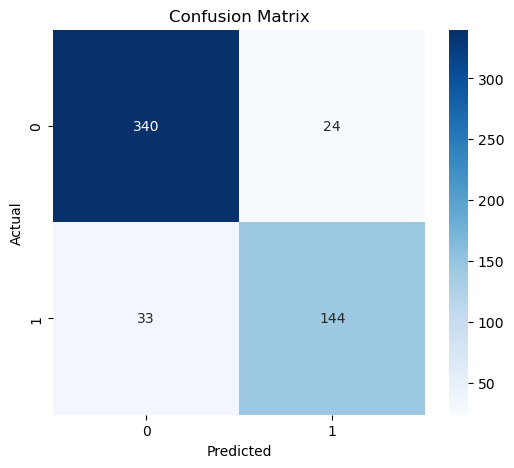

In [32]:
# Confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


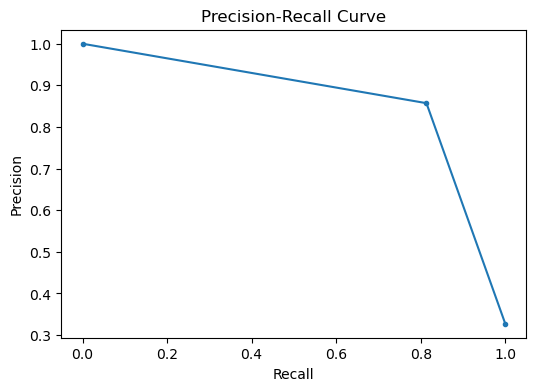

In [33]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(all_y_true, all_y_pred)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

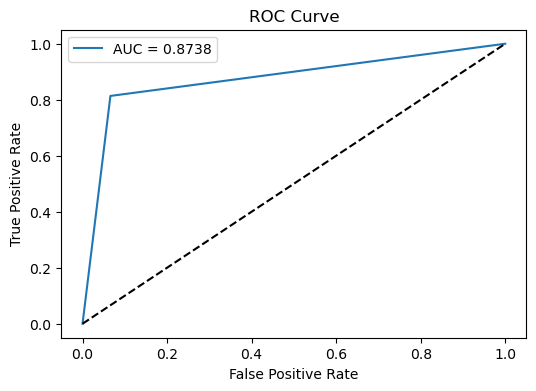

In [34]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(all_y_true, all_y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [35]:
# Save Models
joblib.dump(rf_model, "rf_model.pkl")
encoder.save("autoencoder_encoder.h5")
print("Models saved: rf_model.pkl, autoencoder_encoder.h5")

Models saved: rf_model.pkl, autoencoder_encoder.h5
